In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Initialization

In [2]:
# manually define building names
buildingnames = ['YUAG',
                 'Berkeley',
                 'Hopper',
                 '304Elm',
                 'Davenport',
                 '38HH',
                 '320Temple',
                 '53Wall',
                 'Sprague',
                 'Malone',
                 'Trumbull',
                 '17HH']



In [3]:
# read elec data from csv into a new dataframe
raw = pd.read_csv('../data/elec_raw.csv',index_col=0,na_values=['#########'])

# remove precalculated demand values, which tend to be bugged
raw = raw.drop(raw.columns[np.arange(0,len(buildingnames)*2,2)], axis=1)

# reindex appropriately by hourly datetime
raw.index = pd.to_datetime(raw.index,format='%a %m/%d/%y %H:00')

# add missing rows by full reindexing
correct_dt = pd.DatetimeIndex(start='2018-01-01 00:00:00',end='2018-07-27 23:00:00',freq='h')
raw = raw.reindex(index=correct_dt)

# rename columns
raw.columns = buildingnames

In [4]:
# create "raw" demand dataframe for plotting later on
raw_plots = raw.diff().drop(raw.index[0])

In [5]:
# remove impossible outliers based on negative percent change
raw_head = raw.iloc[0]
raw = raw.where(raw.pct_change(limit=1)>0)
raw.iloc[0] = raw_head

In [6]:
# interpolate gaps in consumption data 6 hours and shorter, optional
for k in raw.columns:
    raw[k] = fn.limited_impute(raw[k],6)

## Error Identification & Removal

In [7]:
# create a new dataframe for hourly demand (kW)
demand = raw.diff().drop(raw.index[0])

# save head to replace later
demand_head = demand.iloc[0:4]

errors = demand.isnull().sum()
print('Missing values:')
print(errors)

# fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

Missing values:
YUAG          86
Berkeley       0
Hopper         0
304Elm        86
Davenport    903
38HH           0
320Temple     89
53Wall        80
Sprague        0
Malone        79
Trumbull      80
17HH          81
dtype: int64


New missing values from this step:
YUAG         0
Berkeley     0
Hopper       0
304Elm       0
Davenport    0
38HH         0
320Temple    0
53Wall       0
Sprague      0
Malone       0
Trumbull     0
17HH         0
dtype: int64


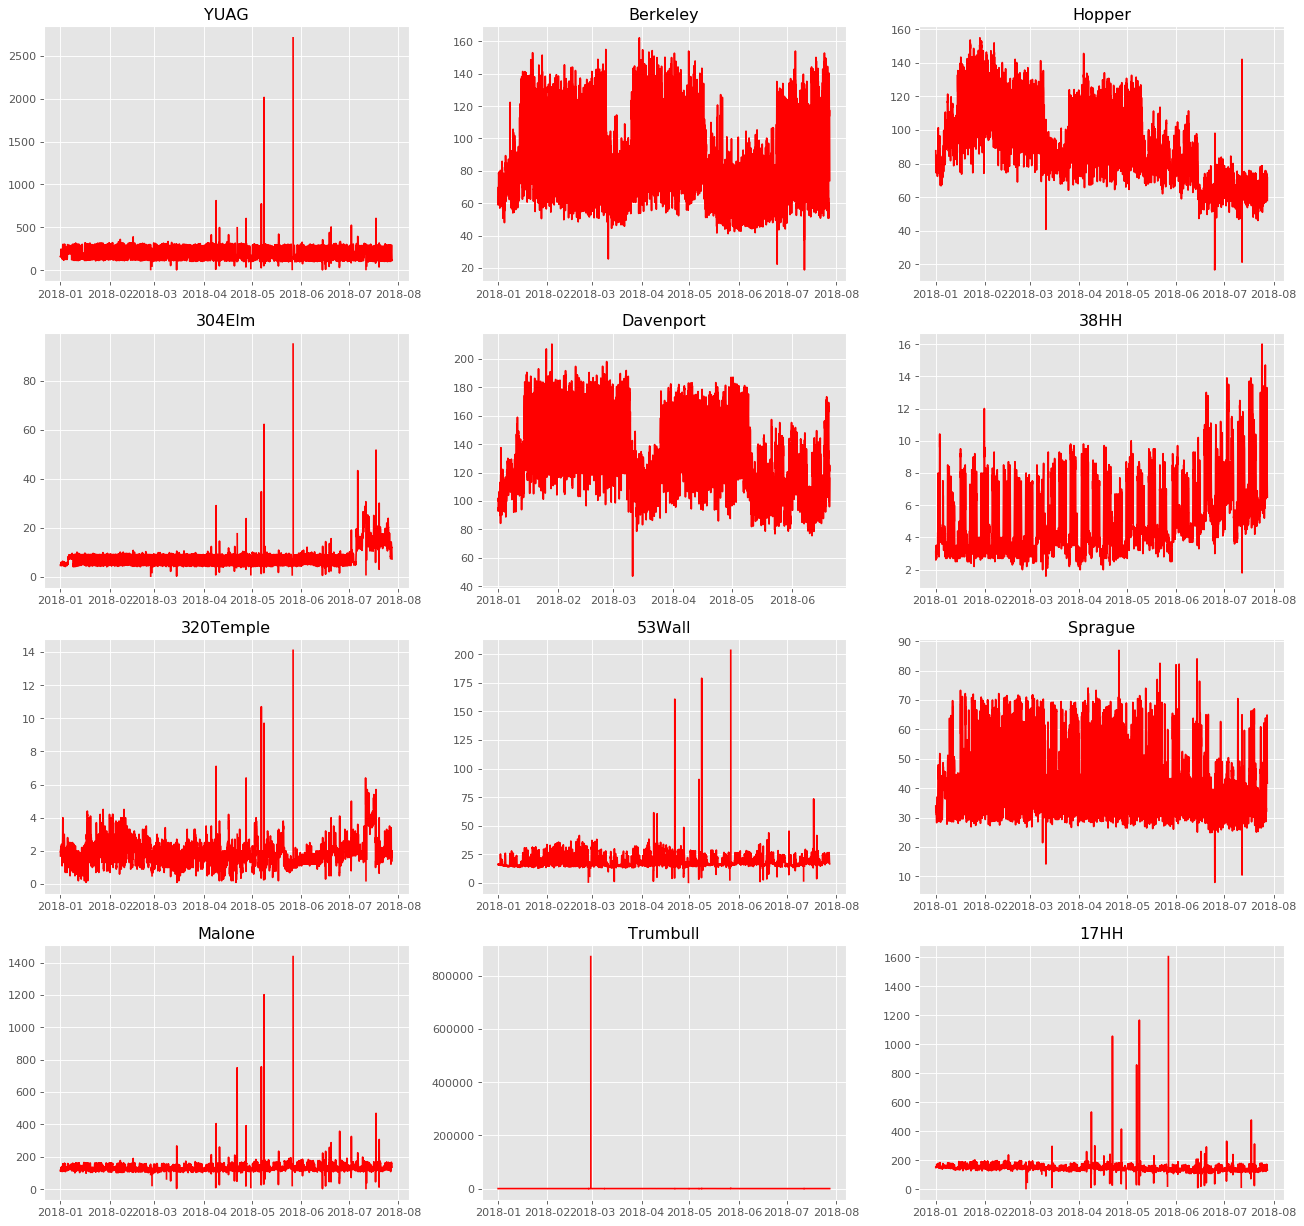

In [8]:
# remove huge statistical outliers
# demand = demand.where(demand > demand.median() - 2.5*demand.std())
# demand = demand.where(demand < demand.median() + 5*demand.std())

new_errors = demand.isnull().sum() - errors
print('New missing values from this step:')
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

New missing values from this step:
YUAG          49
Berkeley      40
Hopper         9
304Elm       132
Davenport     20
38HH          35
320Temple    210
53Wall        71
Sprague       37
Malone        69
Trumbull      78
17HH          64
dtype: int64


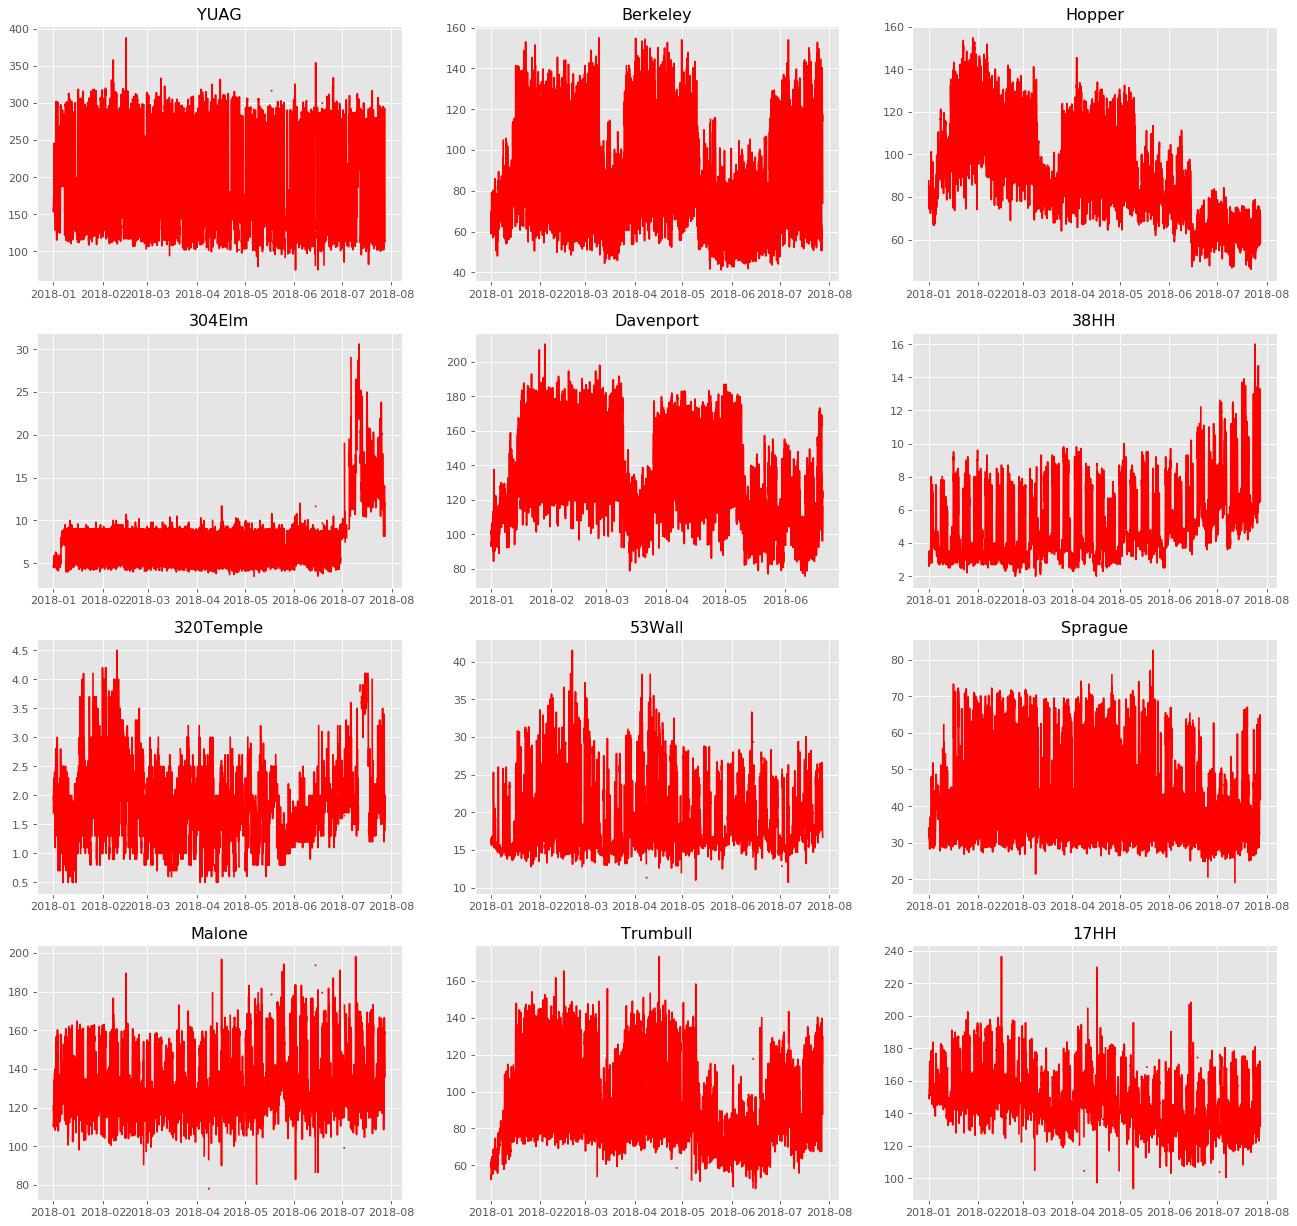

In [9]:
# remove errors by rolling min and max in 15-day chunks
chunk_size = 360
i=0

while i < len(demand):
    end = i+chunk_size
    if end > len(demand): end = len(demand)
    demand[i:end].where(demand[i:end] > demand[i:end].rolling(18).min().median()*0.7, inplace=True)
    demand[i:end].where(demand[i:end] < demand[i:end].rolling(18).max().median()*1.3, inplace=True)
    i = i+chunk_size


new_errors = demand.isnull().sum() - errors
print('New missing values from this step:')
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

## Imputation of missing values

Number of missing values remaining:
YUAG         102
Berkeley       0
Hopper         0
304Elm       169
Davenport    902
38HH           7
320Temple    171
53Wall       110
Sprague        0
Malone       110
Trumbull     117
17HH         112
dtype: int64


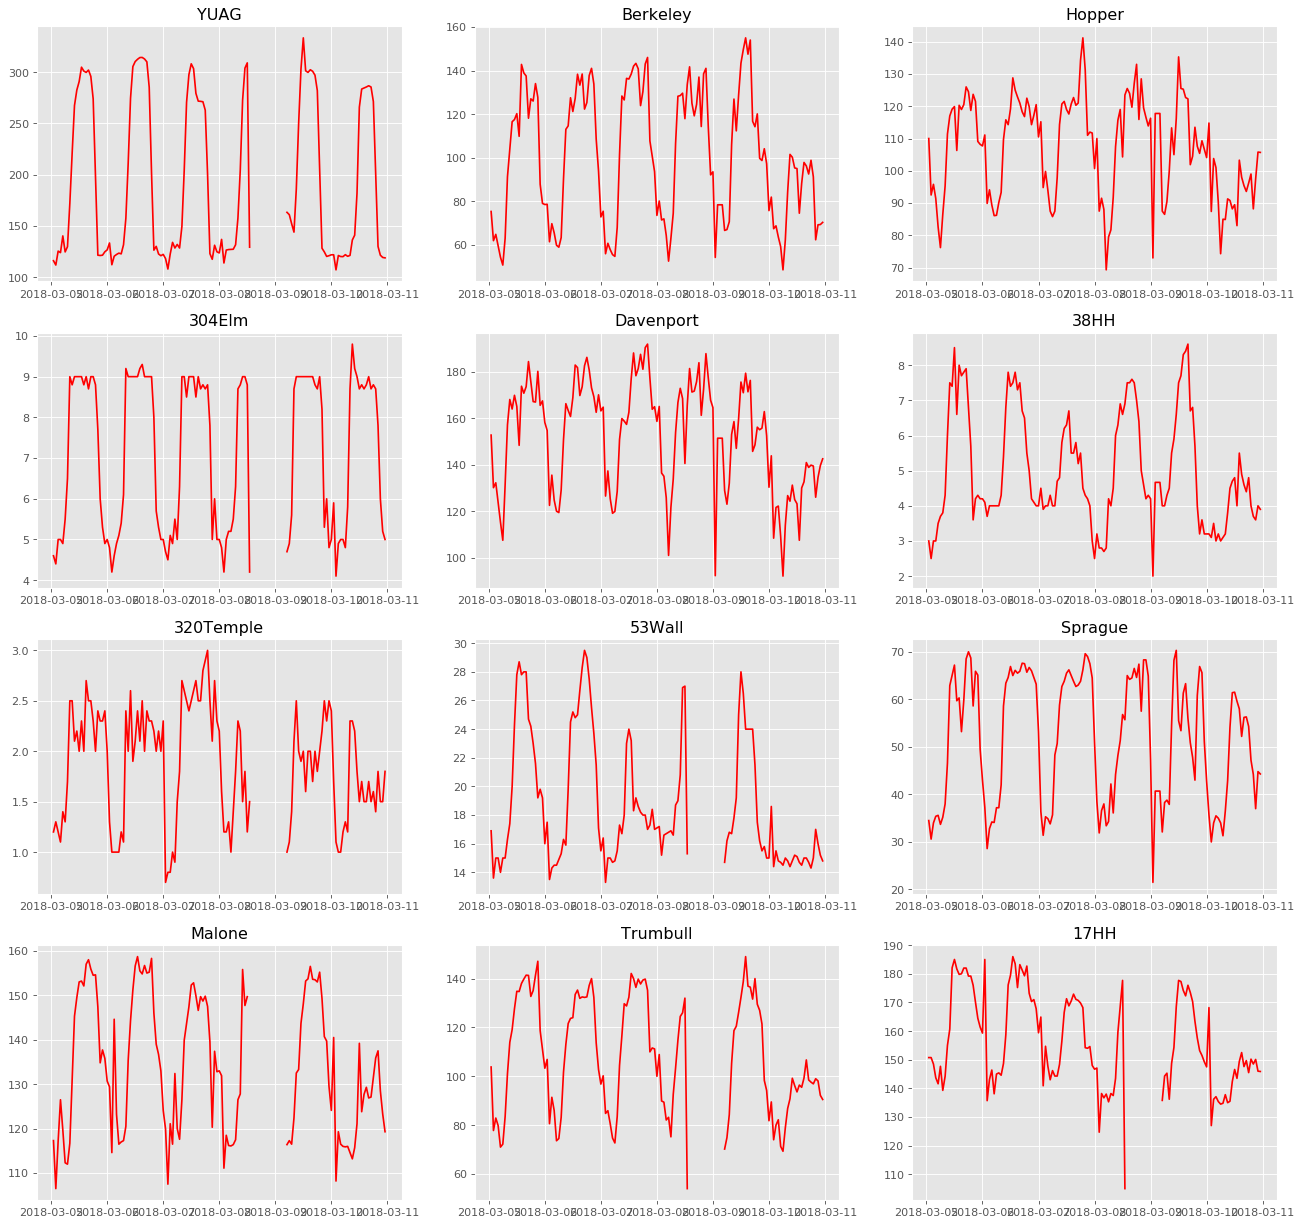

In [10]:
dense = demand.copy(deep=True)

# interpolate gaps shorter than 6 hours
for k in dense.columns:
    dense[k] = fn.limited_impute(dense[k],6)

print('Number of missing values remaining:')
print(dense.isnull().sum())

fn.plot_all(dense,'2018-03-05 01:00:00','2018-03-10 23:00:00')

/Users/kevinkoste/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kevinkoste/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


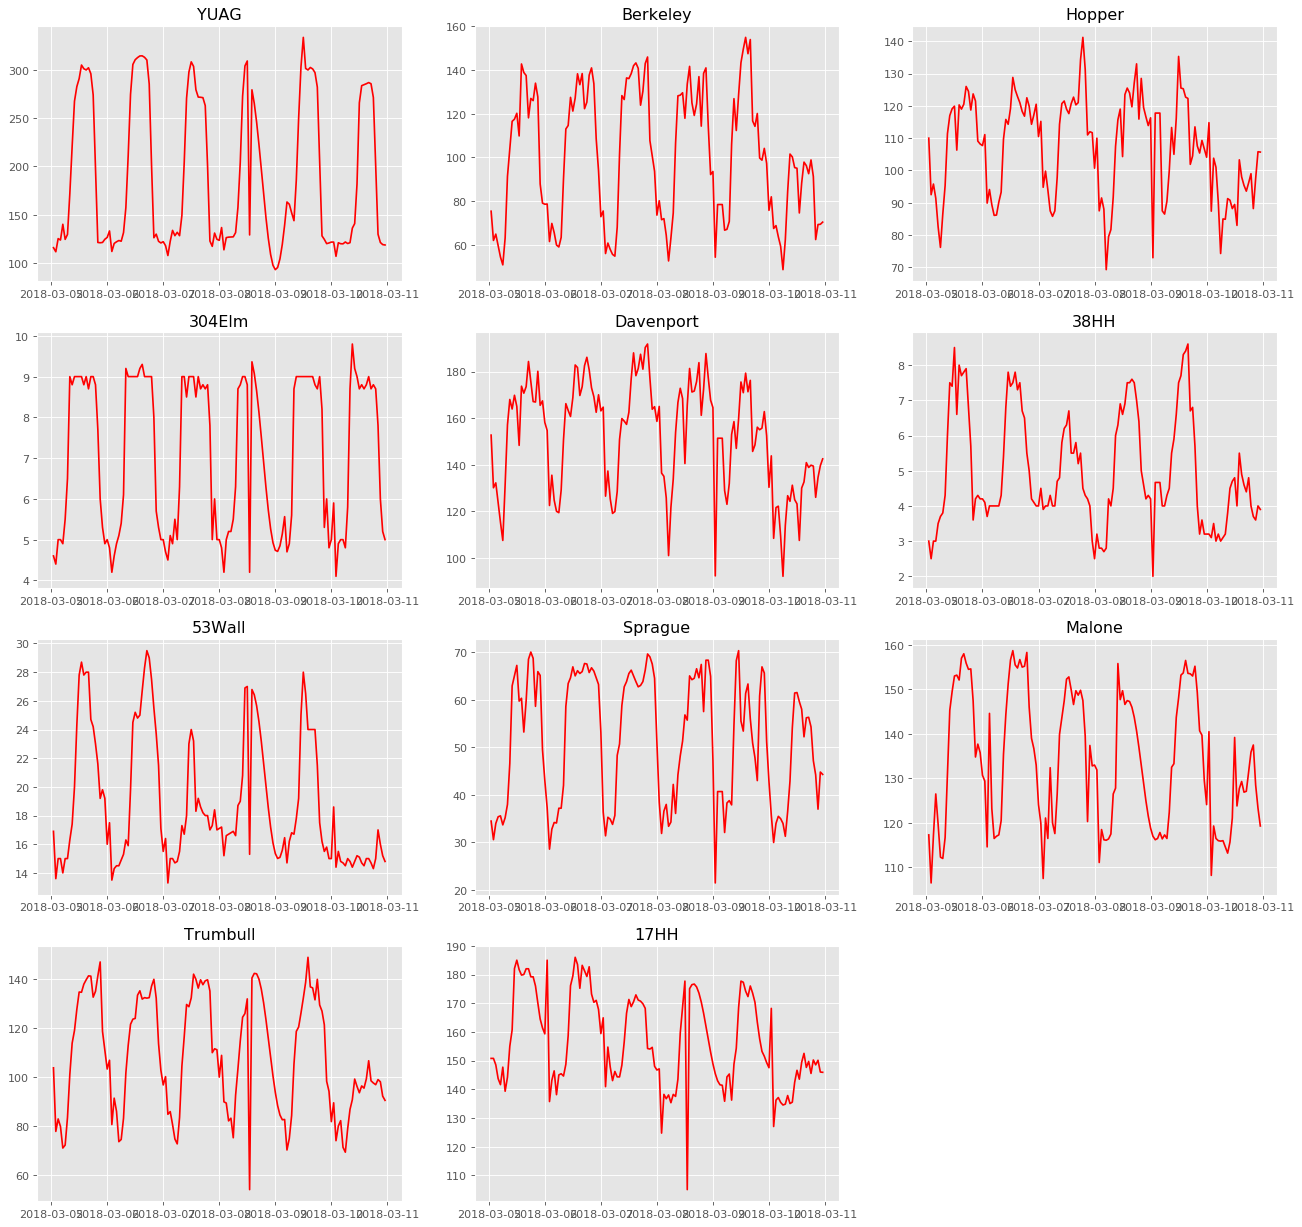

In [11]:
# drop 320Temple for now, data in July is too messy for sinusoidal interpolation
dense = dense.drop('320Temple', axis=1)

# interpolate gaps longer than 6 hours using least-squares optimized sinusoidal fit
for k in dense.columns:
    dense[k] = fn.sine_impute(dense[k])

# print('Number of missing values remaining:')
# print(dense.isnull().sum())

fn.plot_all(dense,'2018-03-05 01:00:00','2018-03-10 23:00:00')

## Export

In [12]:
# replace head for final export
dense.iloc[0:4] = demand_head.drop('320Temple',axis=1)

# export clean data to csv
# dense.round(1).to_csv('../data/elec_clean.csv')

## Plots for export

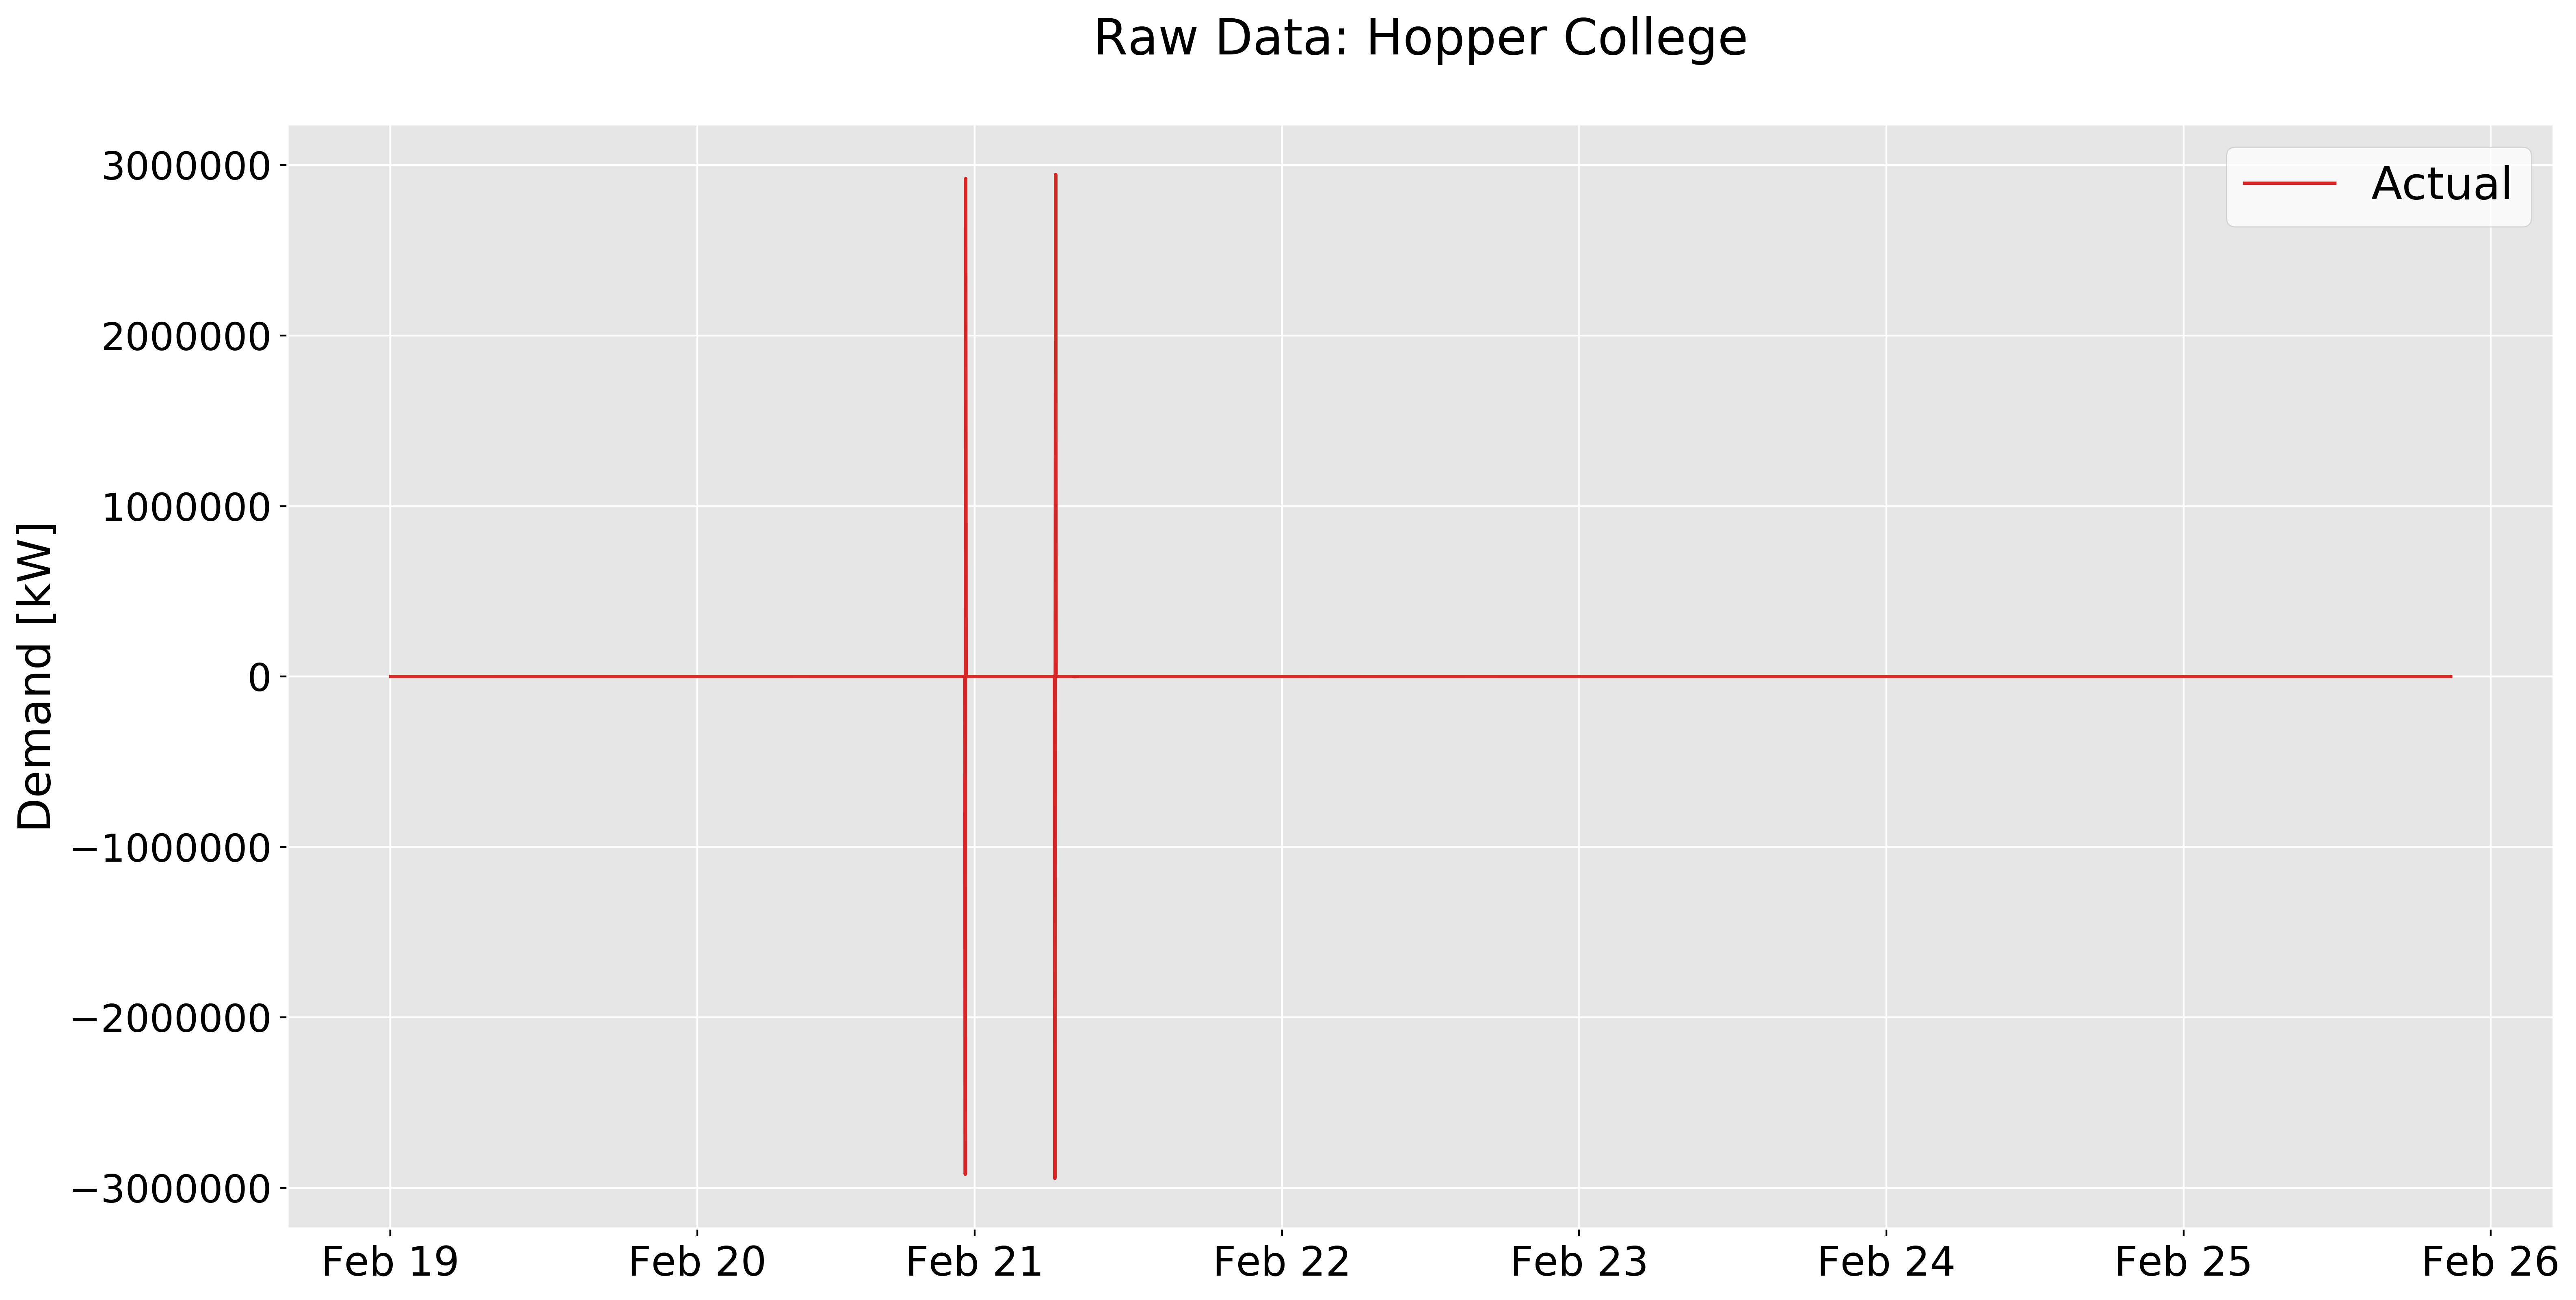

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9),dpi=400)

plt.title('Raw Data: Hopper College\n',size=22)

ax.plot(raw_plots.index,raw_plots['Hopper'].values,color='tab:red',label='Actual')
ax.set_ylabel('Demand [kW]',color='k',size=20)
# ax.set_ylim(550,1200)
# ax.set_xlim('2018-02-19 00:00:00', '2018-02-26 00:00:00')

ax.tick_params(axis='y',colors='k',labelsize=17)
ax.tick_params(axis='x',colors='k',labelsize=18)

# x_tick_labels = ['Feb 19','Feb 20','Feb 21','Feb 22','Feb 23','Feb 24','Feb 25','Feb 26']
# ax.set_xticklabels(x_tick_labels)

# fig.savefig('../figures/sarima_bestweek.png', bbox_inches='tight')

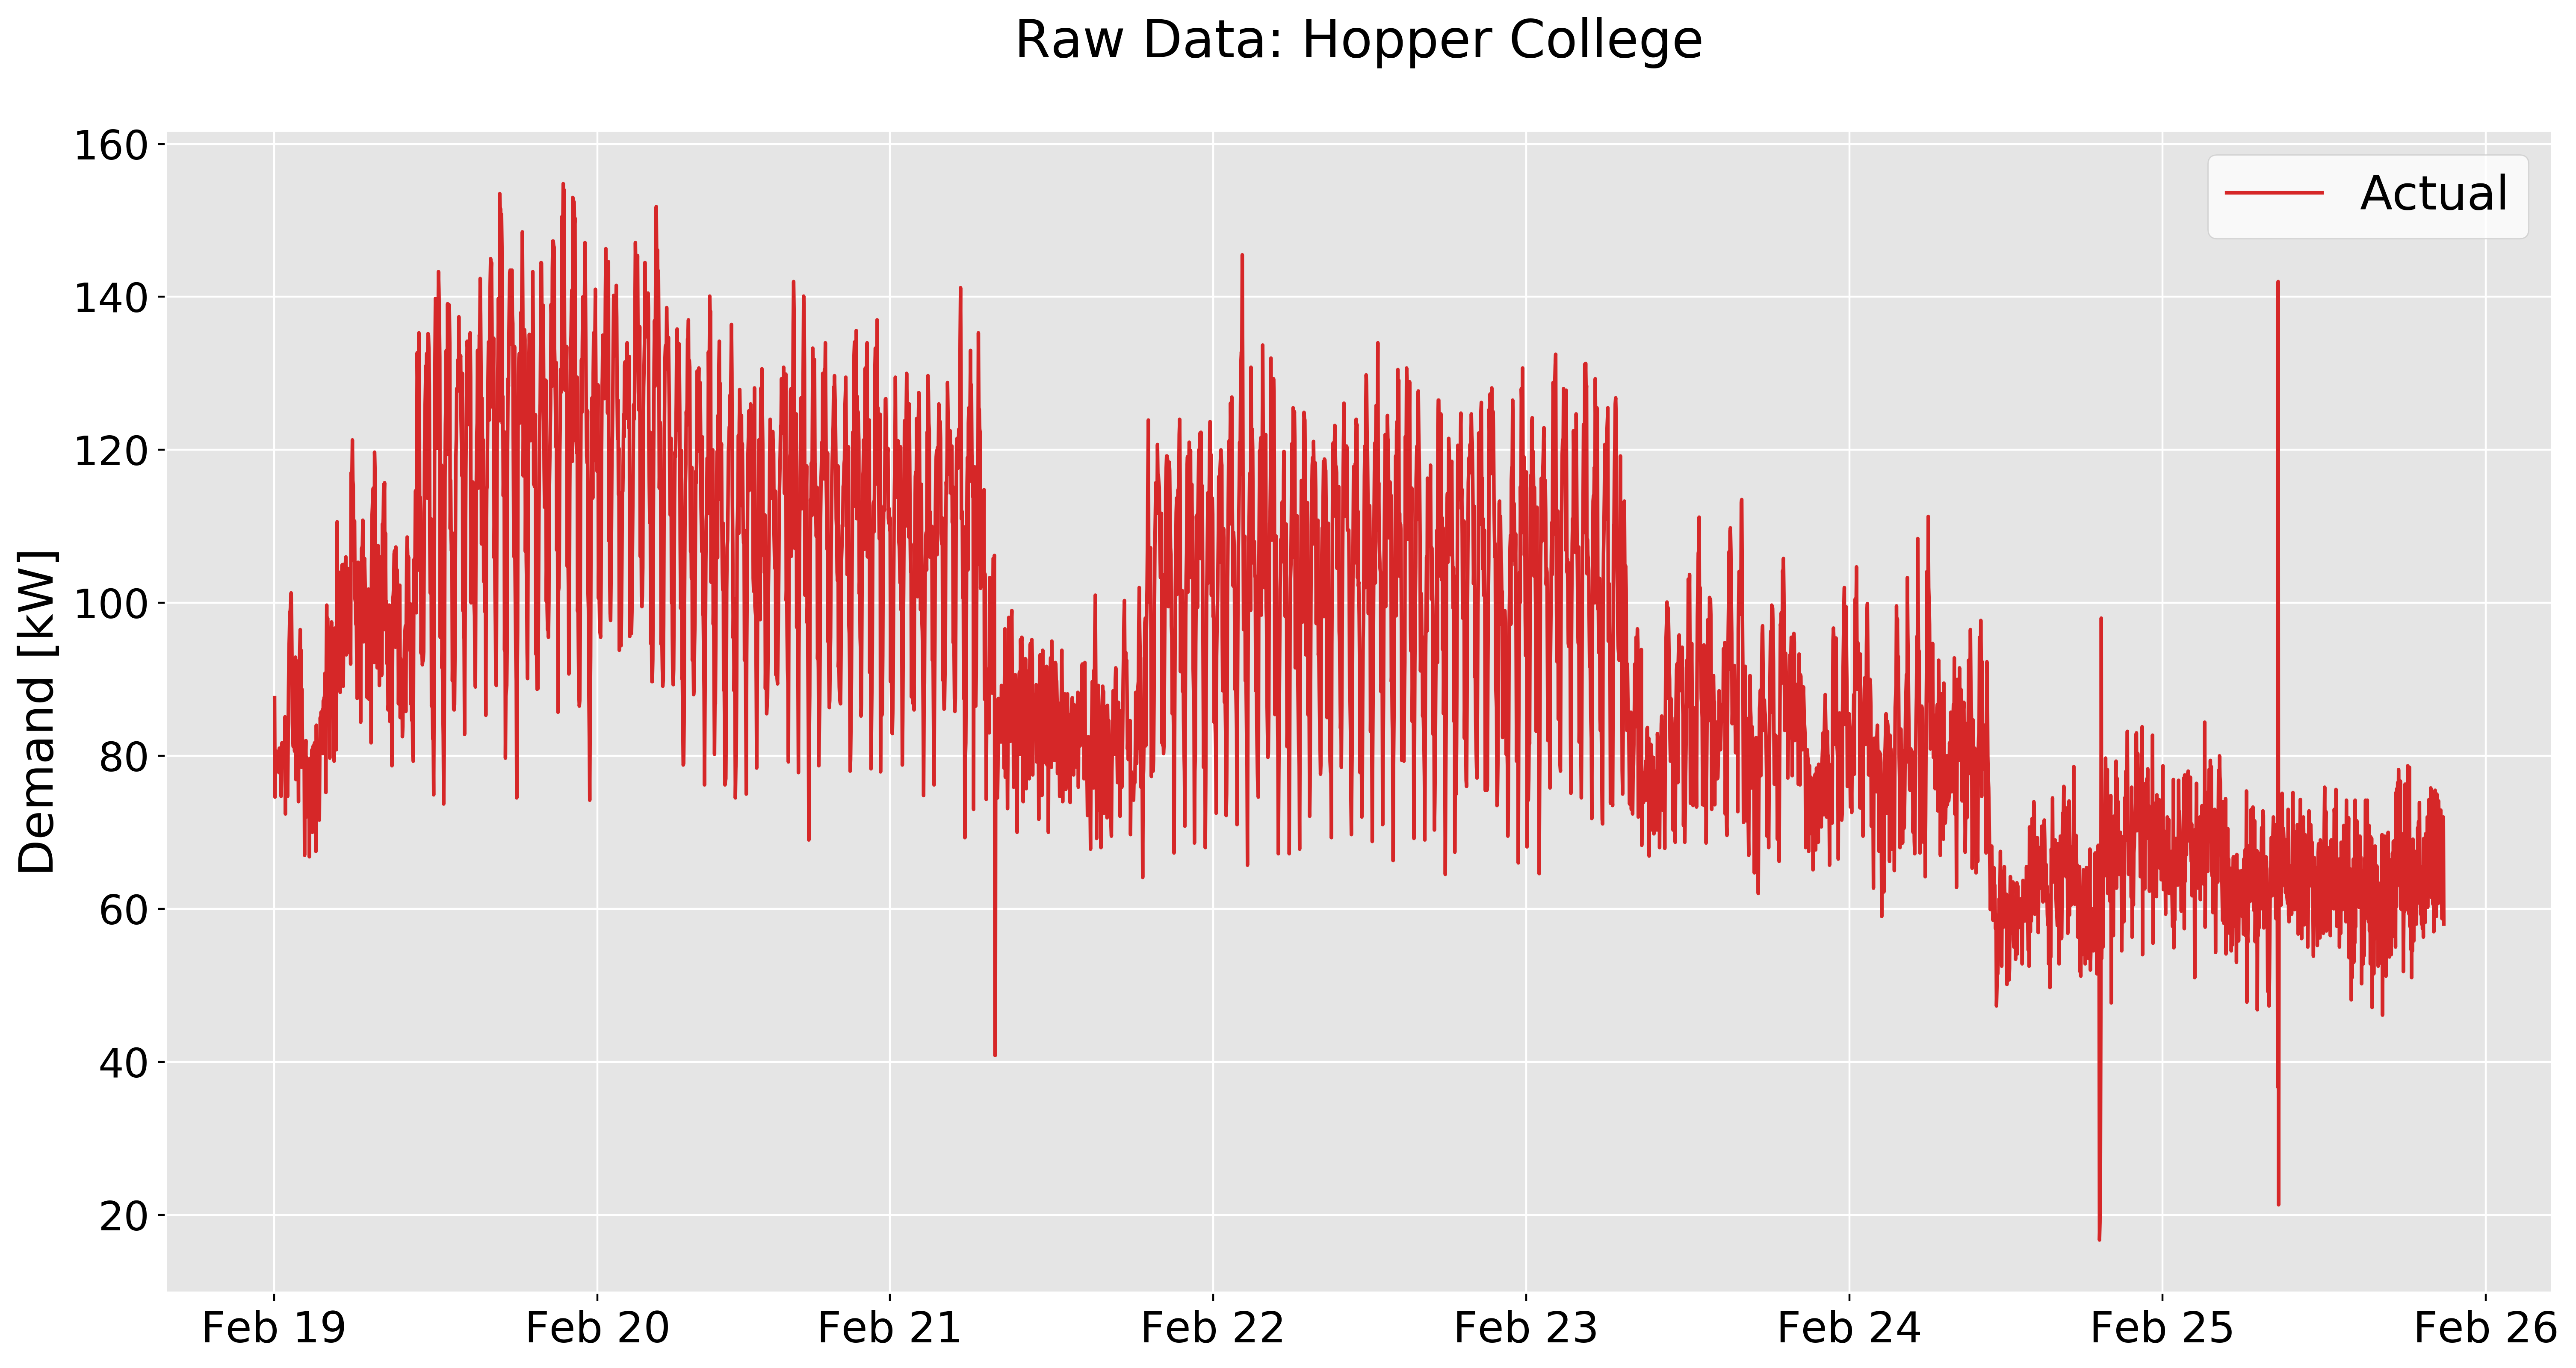

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9),dpi=400)

plt.title('Raw Data: Hopper College\n',size=22)

raw_plots2 = raw.diff().drop(raw.index[0])
ax.plot(raw_plots2.index,raw_plots2['Hopper'].values,color='tab:red',label='Actual')
ax.set_ylabel('Demand [kW]',color='k',size=20)
# ax.set_ylim(550,1200)
# ax.set_xlim('2018-02-19 00:00:00', '2018-02-26 00:00:00')

ax.tick_params(axis='y',colors='k',labelsize=17)
ax.tick_params(axis='x',colors='k',labelsize=18)

x_tick_labels = ['Feb 19','Feb 20','Feb 21','Feb 22','Feb 23','Feb 24','Feb 25','Feb 26']
ax.set_xticklabels(x_tick_labels)

ax.legend(fontsize=20,facecolor='w')

# fig.savefig('../figures/sarima_bestweek.png', bbox_inches='tight')

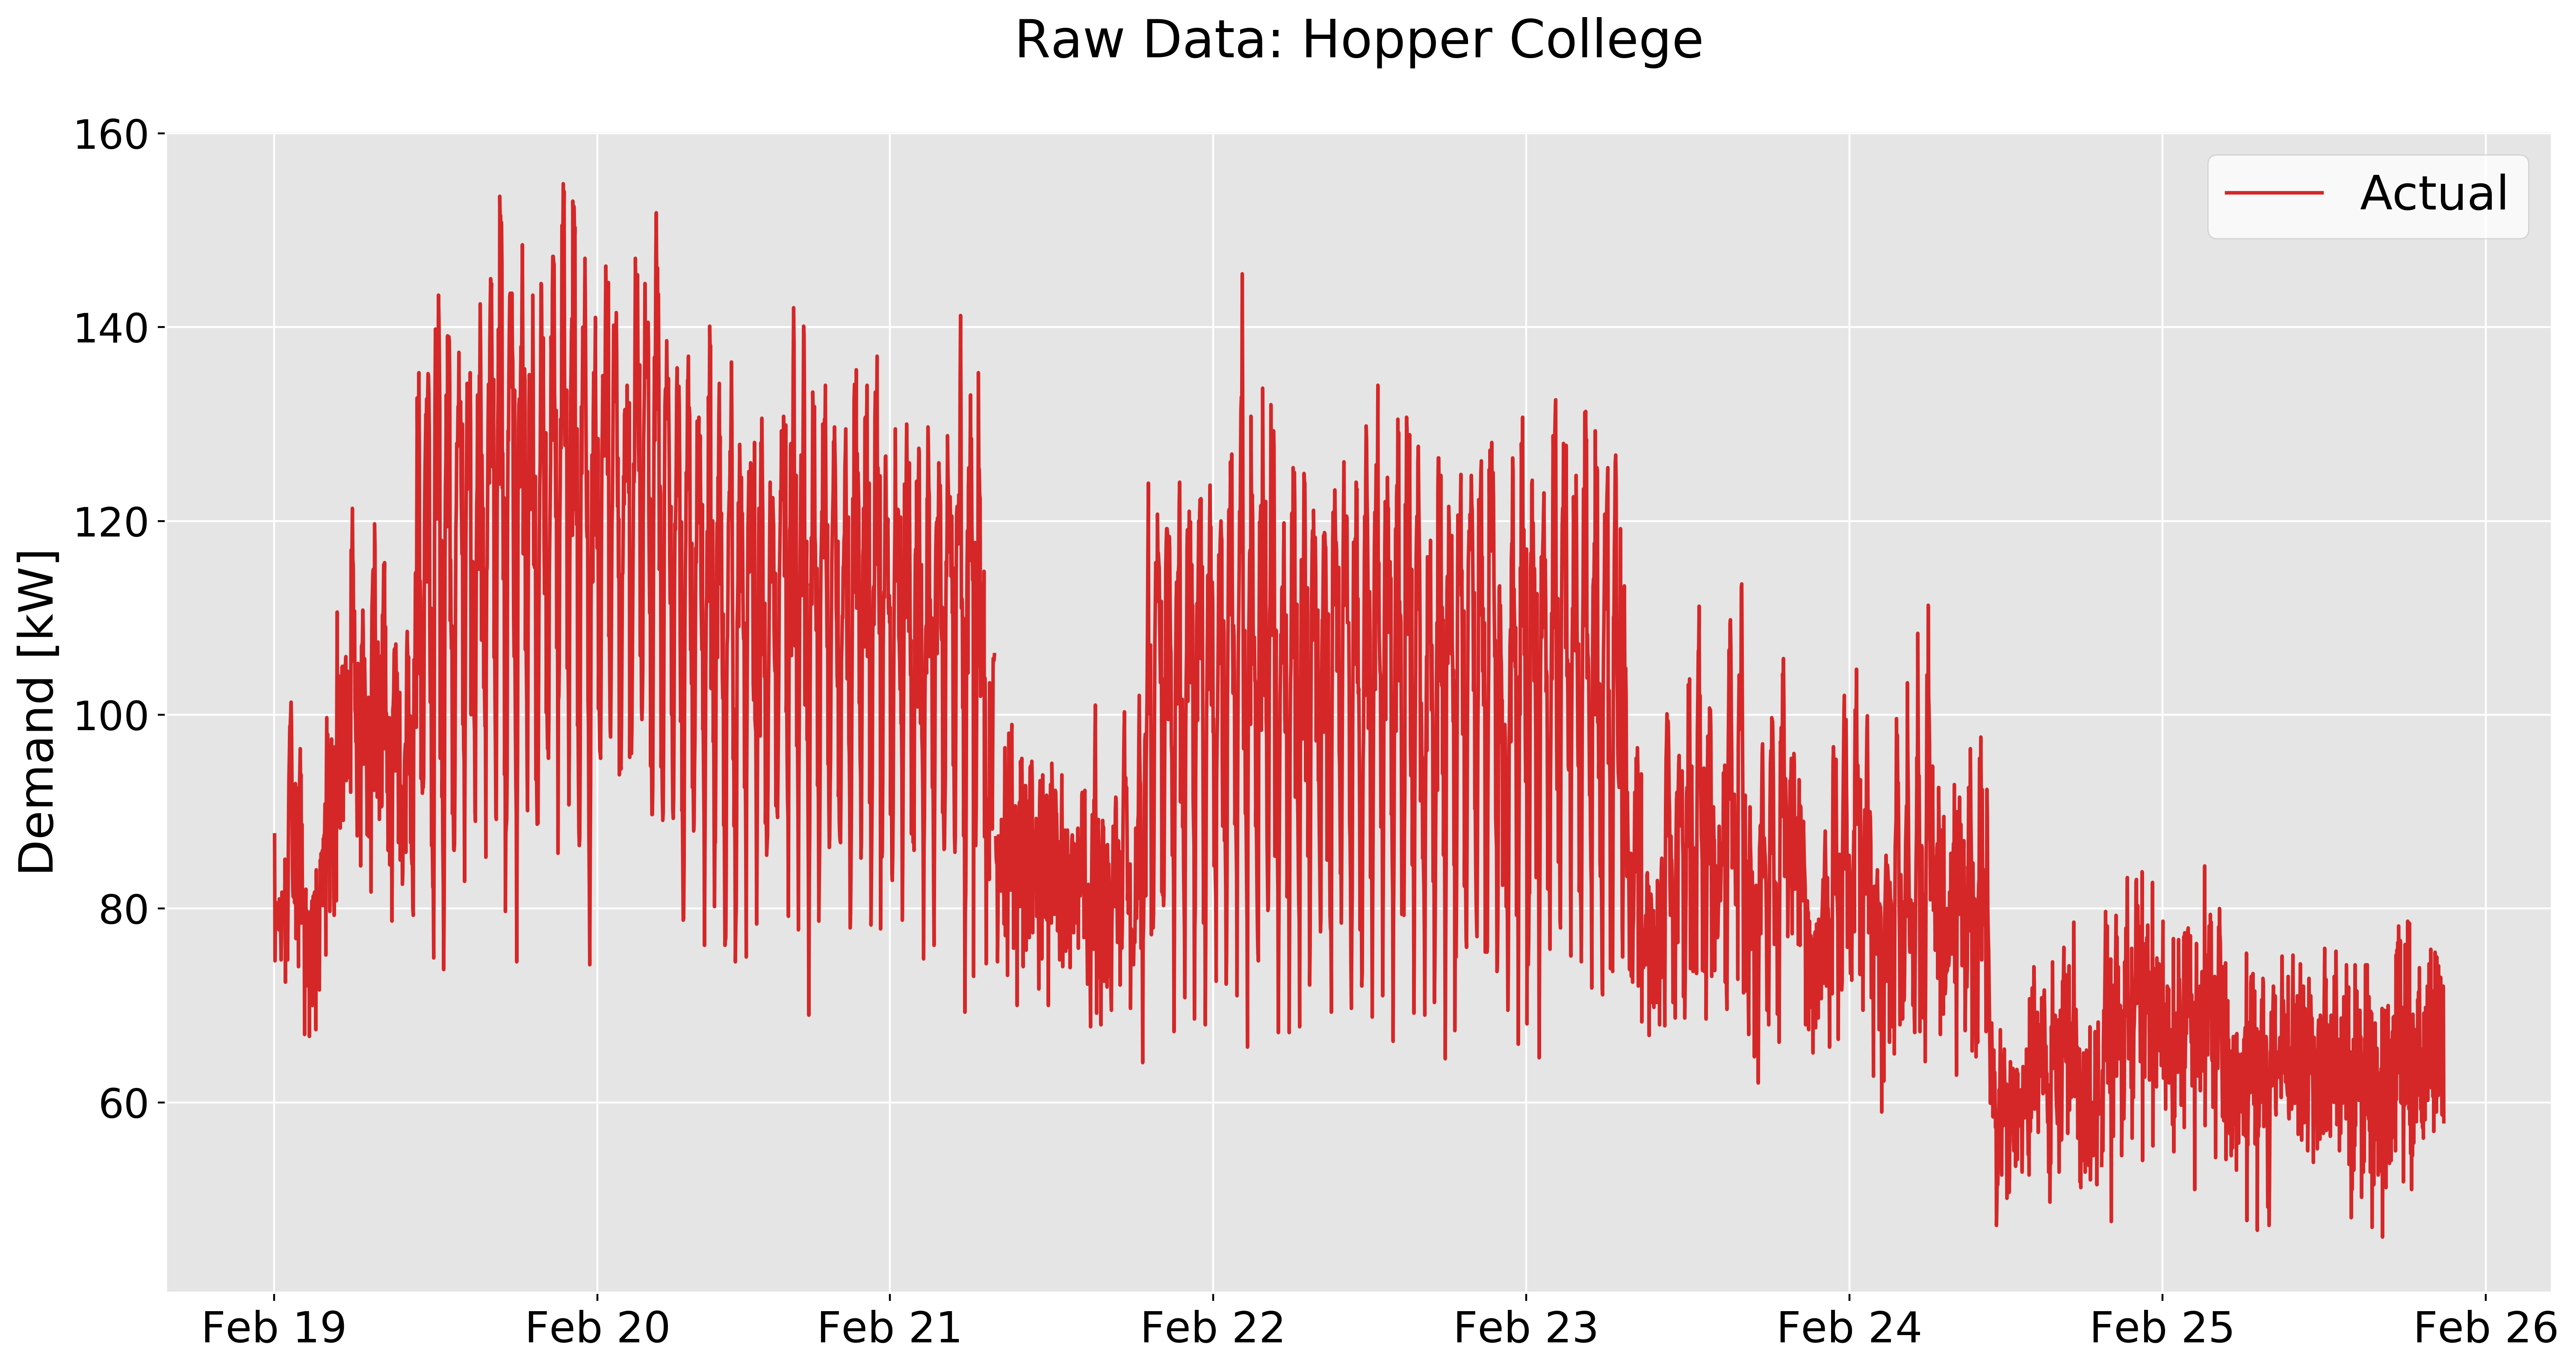

In [22]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9),dpi=400)

plt.title('Raw Data: Hopper College\n',size=22)

raw_plots2 = raw.diff().drop(raw.index[0])
ax.plot(demand.index,demand['Hopper'].values,color='tab:red',label='Actual')
ax.set_ylabel('Demand [kW]',color='k',size=20)
# ax.set_ylim(550,1200)
# ax.set_xlim('2018-02-19 00:00:00', '2018-02-26 00:00:00')

ax.tick_params(axis='y',colors='k',labelsize=17)
ax.tick_params(axis='x',colors='k',labelsize=18)

x_tick_labels = ['Feb 19','Feb 20','Feb 21','Feb 22','Feb 23','Feb 24','Feb 25','Feb 26']
ax.set_xticklabels(x_tick_labels)

ax.legend(fontsize=20,facecolor='w')

# fig.savefig('../figures/sarima_bestweek.png', bbox_inches='tight')